# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Supplementary: Audio feature extraction

**Note**: This notebook is an ungraded, supplementary notebook, provided as pre-reading for the 'Speech Emotion Recognition' Mini-project. This will help you to understand the various audio features and get introduced to the tools and packages used in audio feature extraction.

## Learning Objectives

In this supplementary notebook, you will be able to:

* record audio samples and save it
* load the audio data from the dataset
* extract the features of the audio data

### Dataset

The [SAVEE](http://kahlan.eps.surrey.ac.uk/savee/) database was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. It contains 480 British English utterances in different emotions. Emotion has been described psychologically in discrete categories: anger, disgust, fear, happiness, sadness and surprise.'Neutral' emotion was added to provide recordings of 7 emotion categories. The text material consisted of 15 sentences per emotion: 3 common, 2 emotion-specific and 10 generic sentences that were different for each emotion and phonetically-balanced. The 3 common and 2 × 6 = 12 emotion-specific sentences were recorded as neutral to give 30 neutral sentences.

  - This resulted in a total of 120 utterances per speaker, for example:

      - Common: She had your dark suit in greasy wash water all year.
      - Anger: Who authorized the unlimited expense account?
      - Disgust: Please take this dirty table cloth to the cleaners for me.
      - Fear: Call an ambulance for medical assistance.
      - Happiness: Those musicians harmonize marvelously.
      - Sadness: The prospect of cutting back spending is an unpleasant one for any governor.
      - Surprise: The carpet cleaners shampooed our oriental rug.
      - Neutral: The best way to learn is to solve extra problems.

### Download the dataset

In [33]:
# !wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/SaveeData.zip
# !unzip -qq SaveeData.zip

from utility import download_and_unzip

download_and_unzip(
    filename="SaveeData.zip",
    url="https://cdn.iisc.talentsprint.com/CDS/MiniProjects/SaveeData.zip",
)


False

In [34]:
# Install packages
# !pip -qq install librosa soundfile


### Import required packages

In [35]:
import librosa
import librosa.display
import soundfile
import re
import os, glob, pickle
import numpy as np
from matplotlib import pyplot as plt
import IPython.display as ipd
from datetime import datetime
from IPython.display import Javascript

# from google.colab import output
from base64 import b64decode


### Record Audio sample

We will use the Javascript from IPython that will enable us to record the audio.

* Create a directory to store all the recordings
* Naming convention of the audio sample is `Audio_DateTime_label.wav`, For eg, *Audio_2021-06-20_11-30-30_angry.wav*
* Upon calling the function `record()`, it prompts to enter the emotion (label) to name the file.

While recording the audio, the utterance can be "*Say the word boat*" and you can show variation in the emotion

In [36]:
# Create a directory
if not os.path.exists("Records"):
    os.mkdir("Records")


In [37]:
# RECORD = """
# const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
# const b2text = blob => new Promise(resolve => {
#   const reader = new FileReader()
#   reader.onloadend = e => resolve(e.srcElement.result)
#   reader.readAsDataURL(blob)
# })
# var record = time => new Promise(async resolve => {
#   stream = await navigator.mediaDevices.getUserMedia({ audio: true })
#   recorder = new MediaRecorder(stream)
#   chunks = []
#   recorder.ondataavailable = e => chunks.push(e.data)
#   recorder.start()
#   await sleep(time)
#   recorder.onstop = async ()=>{
#     blob = new Blob(chunks)
#     text = await b2text(blob)
#     resolve(text)
#   }
#   recorder.stop()
# })
# """

# def record(sec=3):
#     emt = input("Enter emotion(label) to save the recording: ")
#     print("Start speaking!")
#     now = datetime.now()
#     current_time = now.strftime("%Y-%m-%d_%H-%M-%S")
#     display(Javascript(RECORD))
#     s = output.eval_js('record(%d)' % (sec*1000))
#     b = b64decode(s.split(',')[1])
#     with open('Records/audio_'+current_time+"_"+emt+'.wav','wb') as f:
#       f.write(b)
#     return 'Records/audio_'+current_time+"_"+emt+'.wav'


In [38]:
# call the function to record a sample
# record()


In [39]:
# change the path and listen to recorded audio sample
# ipd.Audio("SaveeData/JE/a08.wav")


### Load the dataset

In [40]:
# The glob module is used to retrieve files/pathnames matching a specified pattern.
# It is faster than other methods to match pathnames in directories
wav_files = glob.glob("SaveeData/*/*.wav")
len(wav_files)


480

### Explore the data and visualize

#### Various emotions in given dataset

In [41]:
wav_files[0]


'SaveeData/KL/n17.wav'

In [42]:
emotions_ = []
mapping = {
    "a": "angry",
    "f": "fear",
    "d": "disgust",
    "h": "happiness",
    "sa": "sadness",
    "su": "surprise",
    "n": "neutral",
}
for file_name in wav_files:
    emotions_.append(
        mapping[re.sub("[0-9]*", "", file_name.split("/")[-1].split(".")[0])]
    )
set(emotions_)


{'angry', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise'}

In [43]:
len(emotions_)


480

#### Speech/Audio analysis Python Package: **Librosa**

[Librosa](https://librosa.org/doc/latest/index.html) is a Python package for audio and music signal processing. At a high level, librosa provides implementations of a variety of common functions and helps in audio feature extraction and manipulation, segmentation, visualization, and display of feature representations.

#### Visualize sample audio signal using librosa

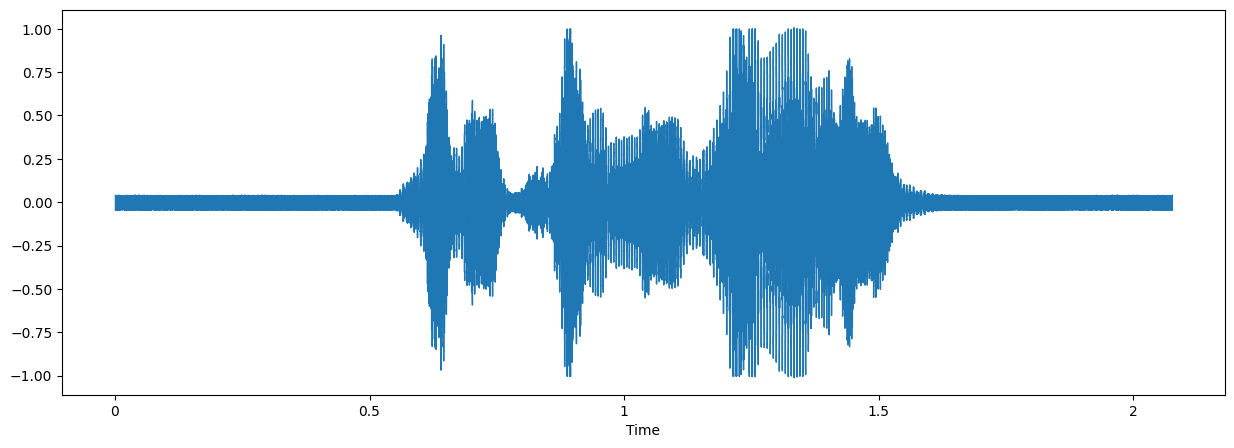

In [44]:
# sample_audio_path = "/content/SaveeData/DC/a03.wav"
sample_audio_path = "./SaveeData/DC/a03.wav"

# librosa is used for analyzing and extracting features of an audio signal
data, sampling_rate = librosa.load(sample_audio_path)
plt.figure(figsize=(15, 5))

# librosa.display.waveshow is used to plot waveform of amplitude vs time
librosa.display.waveshow(data, sr=sampling_rate)
plt.show()


### Audio Features



### Extract features

* Load an audio using `librosa.load()`

    `load()` function loads an audio file and decodes it into a 1-dimensional array which is a time series x , and sr is a sampling rate of x . Default sr is 22kHz.


* Apply short term Fourier transform using `librosa.stft()

    `stft()` converts data into short term Fourier transform. STFT converts signal such that we can know the amplitude of given frequency at a given time. Using STFT we can determine the amplitude of various frequencies playing at a given time of an audio signal.


* Apply Mel-Frequency Cepstral Coefficients (MFCC) using librosa.feature.mfcc

    This feature is one of the most important method to extract a feature of an audio signal and is used majorly whenever working on audio signals. The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope.
    

* Compute a chromagram from a waveform or power spectrogram using librosa.feature.chroma_stft
    
    Chroma features are a powerful tool for analyzing audio whose pitches can be meaningfully categorized (often into twelve categories) and whose tuning approximates to the equal-tempered scale. One main property of Chroma features is that they capture harmonic and melodic characteristics of music, while being robust to changes in timbre and instrumentation.


* Compute a Mel-scaled spectrogram using librosa.feature.melspectrogram
    
    A Mel spectrogram is a spectrogram where the frequencies are converted to the Mel scale. Mel scale is a scale of pitches judged by listeners to be equal in distance one from another.

For more information related to audio based features, refer [here](https://heartbeat.fritz.ai/working-with-audio-signals-in-python-6c2bd63b2daf).

In [45]:
def extract_feature(file_name):
    # load audio
    X, sample_rate = librosa.load(file_name)
    # apply stft()
    stft = np.abs(librosa.stft(X))
    result = np.array([])
    # compute mfcc
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    # combine the features
    result = np.hstack((result, mfccs))
    # compute chroma features and combine
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma))
    # compute melspectrogram and combine
    mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    return result


In [46]:
sample_feature = extract_feature(wav_files[0])  # ,mfcc=True, chroma=True, mel=True)
sample_feature.shape


(180,)

In [47]:
print(sample_feature)


[-6.02695862e+02  1.46858246e+02  2.36849136e+01  1.47652321e+01
  1.02162352e+01 -3.40067148e+00 -5.58810711e+00  4.79318589e-01
 -9.61423302e+00 -1.02569513e+01 -4.05923843e+00 -2.08154464e+00
  7.98277092e+00  2.69199395e+00 -7.98152256e+00  5.46265781e-01
  6.21996403e+00 -3.01850528e-01  1.12216711e+00  6.07819271e+00
 -1.63723135e+00 -3.87582660e+00  1.05261934e+00 -2.09982538e+00
  1.02905488e+00  1.85546589e+00 -2.63606453e+00  2.27125332e-01
  2.66348290e+00  2.50798315e-01 -1.10281312e+00  2.17286170e-01
 -1.62005603e+00 -7.95311153e-01  2.52827930e+00 -1.27844527e-01
 -1.01140106e+00  1.78675801e-01 -2.28522015e+00 -2.44604111e+00
  5.69047630e-01  5.61814785e-01  6.17183566e-01  5.90235710e-01
  5.80731273e-01  5.27267933e-01  5.39131761e-01  5.39826691e-01
  6.00689054e-01  7.09428549e-01  6.53721333e-01  5.56216002e-01
  1.04322387e-02  1.37810042e-04  2.41933740e-03  2.58417018e-02
  3.84946801e-02  3.12550478e-02  2.97471602e-03  2.03022622e-02
  3.50571536e-02  2.50517

In [48]:
type(sample_feature)


numpy.ndarray

### Extract features and labels of all audio samples

'DC', 'JE', 'JK' and 'KL' are four male speakers recorded for the SAVEE database. Audio files consist of audio WAV files..

There are 15 sentences for each of the 7 emotion categories.
The initial letter(s) of the file name represents the emotion class, and the following digits represent the sentence number.
The letters 'a', 'd', 'f', 'h', 'n', 'sa' and 'su' represent 'anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness' and 'surprise' emotion classes respectively.

E.g., '**SaveeData/JK/d03.wav**' is the 3rd disgust sentence.


In [49]:
emotions_savee = {"a": 0, "d": 1, "f": 2, "h": 3, "n": 4, "sa": 5, "su": 6}
emotions_savee


{'a': 0, 'd': 1, 'f': 2, 'h': 3, 'n': 4, 'sa': 5, 'su': 6}

In [50]:
# Declare list to append features and labels
features, labels = [], []

for wv_file in wav_files:
    features.append(extract_feature(wv_file))
    # extracting label
    emt = re.sub("[0-9]*", "", wv_file.split("/")[-1].split(".")[0])
    labels.append(emotions_savee[emt])


In [51]:
len(features), len(labels)


(480, 480)

In [52]:
print(set(labels))


{0, 1, 2, 3, 4, 5, 6}


For further reading on audio acquisition, representation and storage refer the [book](http://www.dcs.gla.ac.uk/~vincia/textbook.pdf): *Camastra and Vinciarelli, 2007, Machine Learning for Audio, Image and Video Analysis*